### In this jupyter notebook, I'm going to figure out the distribution of fitness estimates for genes that are essential and genes that have a true deleterious fitness effect ranging from -45% to -2%. The idea is to find a threshold at which there is no way to distinguish a real fitness effect from essentiality in our experiments

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from Bio.SeqIO.FastaIO import SimpleFastaParser
import re
import pandas as pd
import seaborn as sns

In [2]:
import pathlib
import os

In [49]:
from matplotlib import cm
from scipy.stats import beta, gamma, lognorm, poisson, norm

In [12]:
sns.set_theme()
sns.set_context('paper')

In [3]:
#current working directory
cwd = os.getcwd()
print(cwd)

/Users/anuraglimdi/Desktop/TnSeq_Paper/LTEE-TnSeq_Paper/Analysis/Part_3_TnSeq_analysis/Fitness_estimation


In [4]:
#use the pathlib.Path function to get the parent directories-> goal is to navigate to directory with the metadata
# and the breseq output data
path = pathlib.Path(cwd)
repo = str(path.parents[2])
print(path.parents[2]) #this should be the base directory for the github repository: the exact path will differ for 
#each unique user

/Users/anuraglimdi/Desktop/TnSeq_Paper/LTEE-TnSeq_Paper


In [5]:
metadata_path = repo+'/Metadata/'
#data_path = repo+'/Data/Mutant_Trajectories/'

In [6]:
#input directory with all the counts data
directory = repo+'/Data/Mutant_Trajectories/'
#names of libraries
libraries = ['REL606', 'REL607', 'REL11330', 'REL11333', 'REL11364', 'REL11336', 'REL11339', 'REL11389', 'REL11392', 'REL11342', 'REL11345', 'REL11348', 'REL11367', 'REL11370']
#more interpretable names for the figures in the paper
libraries2 = ['REL606', 'REL607', 'Ara-1', 'Ara-2', 'Ara-3', 'Ara-4', 'Ara-5', 'Ara-6', 'Ara+1', 'Ara+2', 'Ara+3', 'Ara+4', 'Ara+5', 'Ara+6']

In [7]:
#opening the pandas file with all the metadata!
all_data = pd.read_csv(metadata_path+"all_metadata_REL606.txt", sep="\t")
names = all_data.iloc[:,0]
gene_start = all_data.iloc[:,3]
gene_end = all_data.iloc[:,4]
strand = all_data.iloc[:,5]
locations = np.transpose(np.vstack([gene_start,gene_end,strand]))
k12_tags = all_data.iloc[:,2]
uniprot_rel606 = all_data.iloc[:,6]

locations_pseudogenes = np.loadtxt(metadata_path+'pseudogenes_locations_REL606.txt')


In [8]:
#list of genes to be excluded from analysis as they lie within large deletions
exclude_genes = np.loadtxt(repo+"/Analysis/Part_2_WGS_analysis/Deleted_genes_REL606_k12annotated.txt")

exclude_pseudogenes = np.loadtxt(repo+"/Analysis/Part_2_WGS_analysis/Deleted_pseudogenes_REL606_k12annotated.txt")

n_pseudo = exclude_pseudogenes.shape[1]

#fractions of the gene at the 5' and 3' ends to be excluded from analysis because they insertions there may not actually
#be disruptive to protein function
frac5p = 0.1
frac3p = 0.25

In [10]:
with open(metadata_path+"rel606_reference.fasta") as in_handle:
    for title, seq in SimpleFastaParser(in_handle):
        ta_sites = [m.start(0) for m in re.finditer('TA', seq)]
ta_sites = np.array(ta_sites)

#counting how many TA sites are present in each gene
ta_gene = np.zeros(len(names))
for i in range(0,len(names)):
    start = locations[i, 0]
    end = locations[i, 1]
    length = end - start
    #if the gene is on the forward strand
    if locations[i,2]==1:
        #counting sites only in the middle 80% of the gene, excluding 10% at each end
        ta_gene[i] = np.sum((ta_sites > start+length*frac5p)&(ta_sites < end - length*frac3p))
    elif locations[i,2]==-1:
        ta_gene[i] = np.sum((ta_sites < start+length*frac5p)&(ta_sites > end - length*frac3p))

In [11]:
#all the information from the fitness assay condensed into a couple of matrices
counts_all_green = np.zeros([1, 5, len(ta_sites)])
counts_all_red = np.zeros([1, 5, len(ta_sites)])

for k in range(1):
    #loading the new file where I have the counts for each TA site for all time points
    gname = directory+'/green_'+libraries[k]+'_merged_all_TAsites.txt'
    greendata = np.loadtxt(gname)
    rname = directory+'/red_'+libraries[k]+'_merged_all_TAsites.txt'
    reddata = np.loadtxt(rname)
    #now for extracting the UMI corrected coutns
    counts_all_green[k,:,:] = greendata[2:11:2,:]
    counts_all_red[k,:,:] = reddata[2:11:2,:]

### Here, I'm only loading the data for the ancestor REL606

Text(0, 0.5, 'Probability Density')

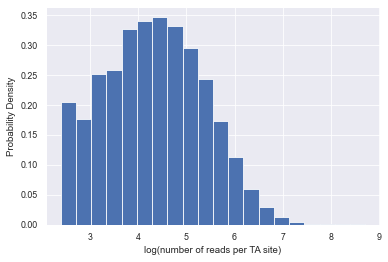

In [15]:
k = 0
data_counts = np.log((counts_all_green[k,0,:][counts_all_green[k,0,:]>10])) #distribution of all sites with > 10 reads
#plotting the fits to the counts per TA site data:
plt.hist(data_counts, bins=20, density=1)
plt.xlabel('log(number of reads per TA site)')
plt.ylabel('Probability Density')

Fitting different distributions to the data

In [70]:
a1, loc1, scale1 = gamma.fit(data_counts, loc=0, scale=0)
param1, param2, param3 = lognorm.fit(data_counts, loc=0, scale=0)
param4, param5 = norm.fit(data_counts, loc=0, scale=0)

Text(0, 0.5, 'Probability Density')

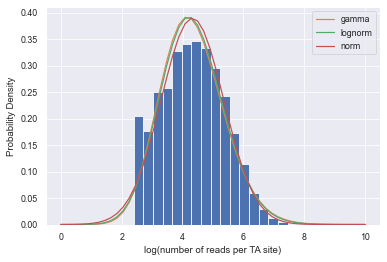

In [52]:
#plotting the fits to the counts per TA site data:
plt.hist(data_counts, bins=20, density=1)
plt.plot(np.linspace(0,10),gamma.pdf(np.linspace(0,10),a1,loc1,scale1 ), label='gamma')
plt.plot(np.linspace(0,10),lognorm.pdf(np.linspace(0,10),param1, param2, param3 ), label='lognorm')
plt.plot(np.linspace(0,10),norm.pdf(np.linspace(0,10),param4, param5 ), label='norm')
plt.legend(loc=0)
plt.xlabel('log(number of reads per TA site)')
plt.ylabel('Probability Density')

### Picking a threshold.
- Iterate over fitness ranging from -45 to -25 %. Simulate fitness estimates under the lognormal t0 reads model
- Simulate fitness estimates under same model for "essential" genes
- Calculate overlap coefficient between the two distributions
- Pick the most deleterious threshold such that overlap coefficient is <5%

#### Simulating fitness effects
- for given fitness effect: reads at new time point are $\dfrac{N_{0}}{100}e^{s} = N_{0}e^{1-s}$
- if a gene is essential: reads at new time point are $\dfrac{N_{0}}{100}$

In [54]:
#generating number of reads at t0 from this distribution
gamma_fit = np.exp(gamma.rvs(a1,loc1,scale1,size=5000))
lognorm_fit = np.exp(lognorm.rvs(param1, param2, param3, size=5000))
norm_fit = np.exp(norm.rvs(param4, param5, size=5000))
#now, estimating the fitness effect for deleterious genes based on this starting n_0
xl = np.random.poisson(lam=lognorm_fit/100,size=5000)
xg = np.random.poisson(lam=gamma_fit/100,size=5000)
xn = np.random.poisson(lam=norm_fit/100,size=5000)

offset = 1
min_s_estimate = np.log((xl+offset)/(lognorm_fit+offset))/6.64
min_s_estimate2 = np.log((xg+offset)/(gamma_fit+offset))/6.64
min_s_estimate3 = np.log((xn+offset)/(norm_fit+offset))/6.64


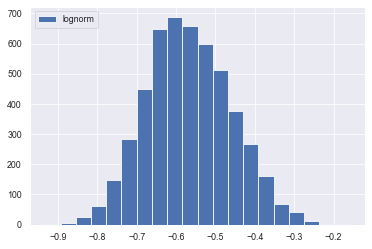

In [61]:
plt.hist(min_s_estimate2, bins=20, label='lognorm')
plt.legend(loc=2)

## Identifying threshold using the gamma distribution fit

overlap coefficient 0.1884


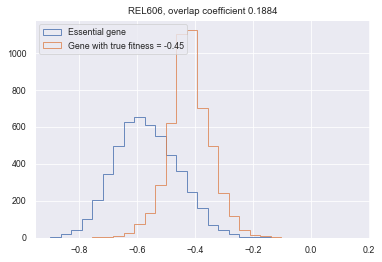

overlap coefficient 0.178


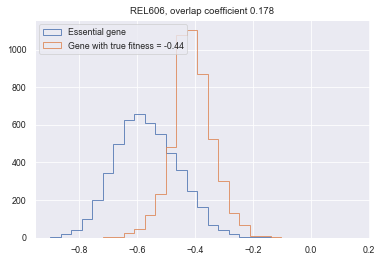

overlap coefficient 0.1685


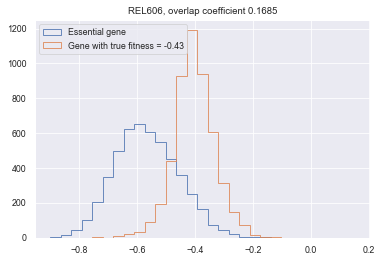

overlap coefficient 0.1562


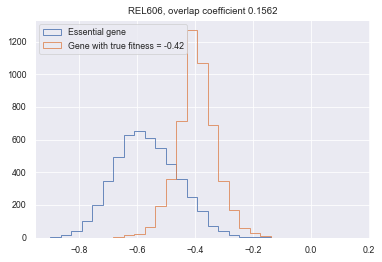

overlap coefficient 0.1424


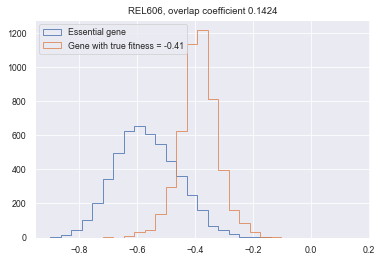

overlap coefficient 0.1282


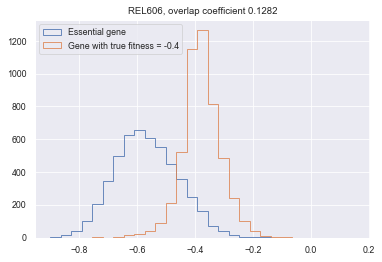

overlap coefficient 0.1203


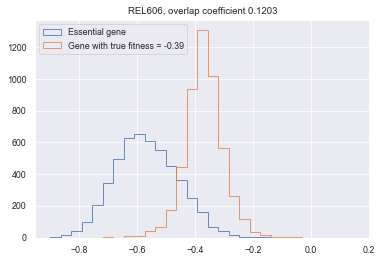

overlap coefficient 0.114


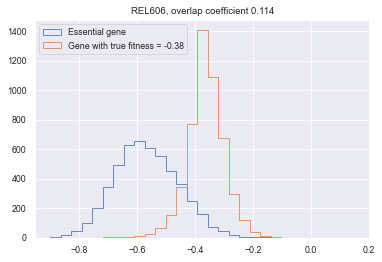

overlap coefficient 0.0987


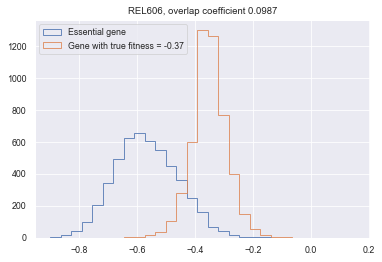

overlap coefficient 0.0865


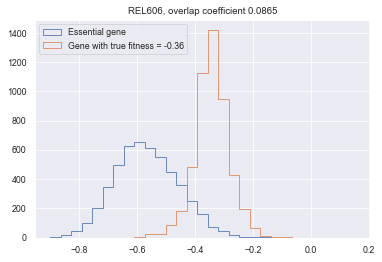

overlap coefficient 0.0796


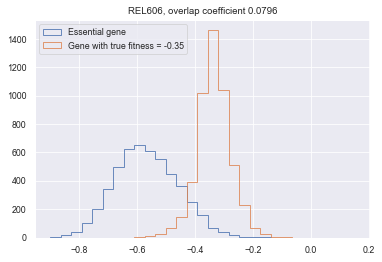

overlap coefficient 0.076


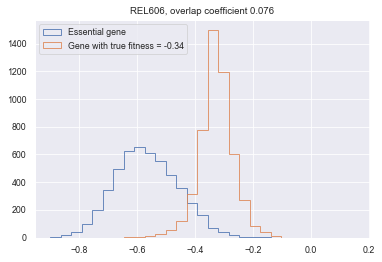

overlap coefficient 0.0707


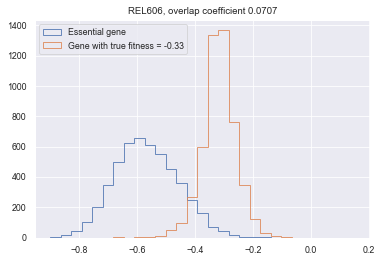

overlap coefficient 0.0583


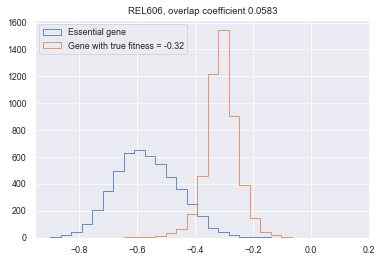

overlap coefficient 0.0509


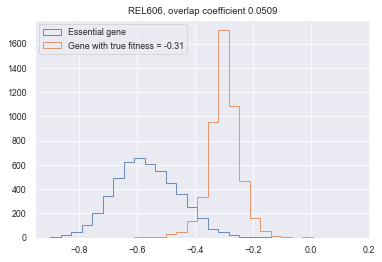

overlap coefficient 0.0468


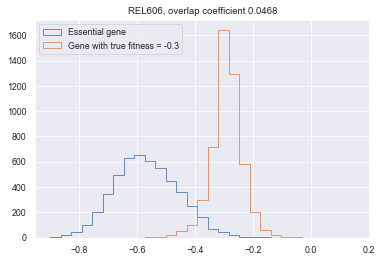

overlap coefficient 0.0417


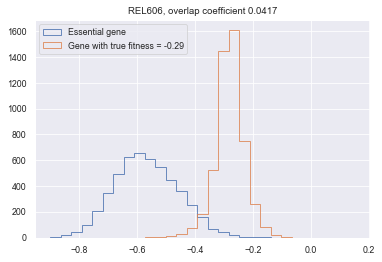

overlap coefficient 0.0374


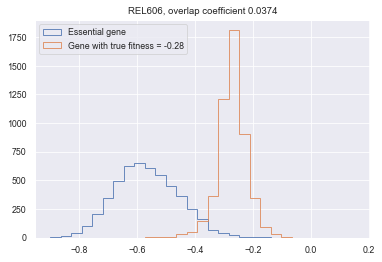

overlap coefficient 0.0294


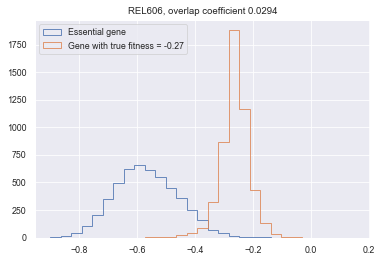

overlap coefficient 0.0244


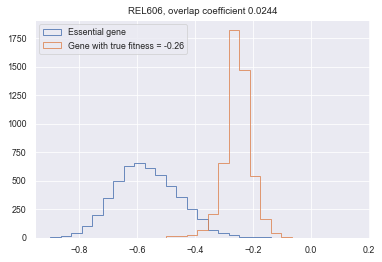

overlap coefficient 0.0231


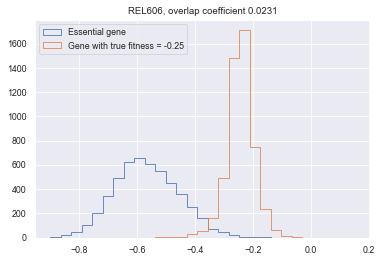

overlap coefficient 0.0203


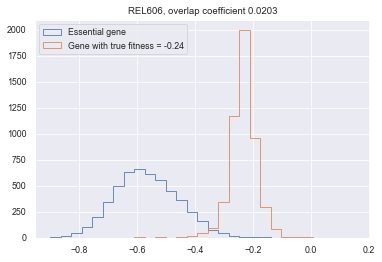

overlap coefficient 0.0186


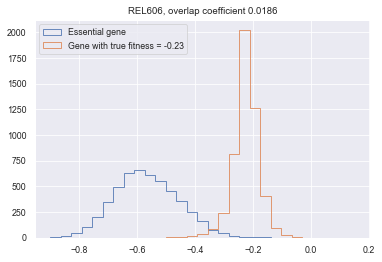

overlap coefficient 0.0148


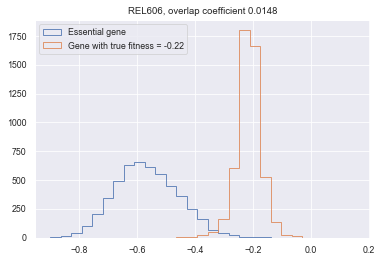

overlap coefficient 0.0134


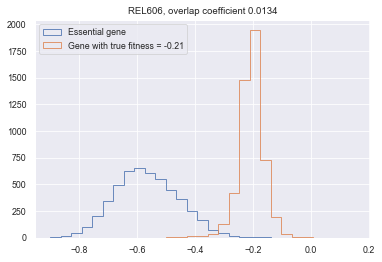

overlap coefficient 0.0109


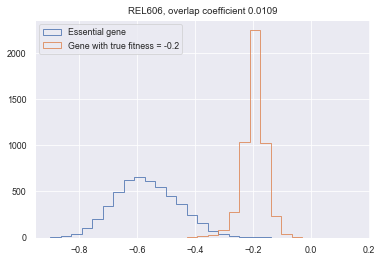

In [63]:
#min_s_estimate: for essential genes with a gamma distribution fit.

#now, I'm going to iterate over a range of fitness effects and compute the distribution of fitness estimates given a
#true fitness estimate

s_range = np.linspace(-0.45, -0.2, 26)
bins = np.linspace(-0.9, 0.15, 30)

for s in s_range:
    #generating random variables from the lognormal distribution
    gamma_fit = np.exp(gamma.rvs(a1,loc1,scale1,size=5000))
    #dilution ratio
    dilution = np.exp(s*6.64)
    xgamma_t1 = np.random.poisson(lam=gamma_fit*dilution, size=5000)
    #fitness estimate:
    s_dist = np.log((xgamma_t1+offset)/(gamma_fit+offset))/6.64
    a = plt.hist(min_s_estimate2, bins=bins, label='Essential gene', histtype='step')
    b = plt.hist(s_dist, bins=bins, label=f'Gene with true fitness = {np.round(s,3)}',histtype='step')
    print('overlap coefficient', np.sum(np.minimum(a[0],b[0]))/10**4)
    plt.legend(loc=2)
    plt.title('REL606, overlap coefficient '+str(np.sum(np.minimum(a[0],b[0]))/10**4))
    plt.show()
#     b = plt.hist(s_dist, bins=30, label=f'Gene with true fitness = {s}',histtype='step')
#     plt.title(f'Expected measurement variability for genes that have true fitness = {np.round(s,3)}')
#     plt.show()

## Identifying the threshold using the normal distribution fit

overlap coefficient 0.1873


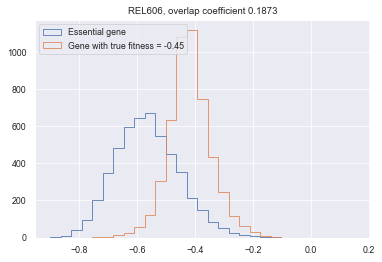

overlap coefficient 0.1787


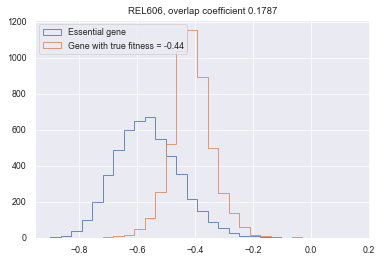

overlap coefficient 0.1679


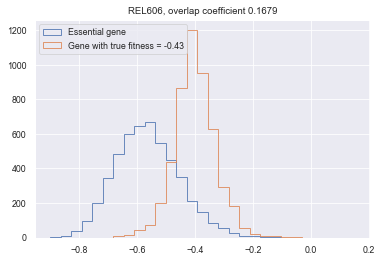

overlap coefficient 0.151


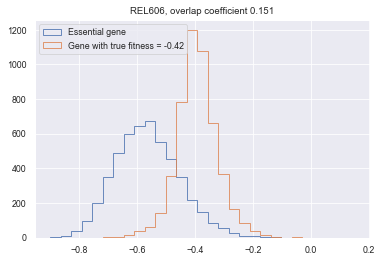

overlap coefficient 0.1395


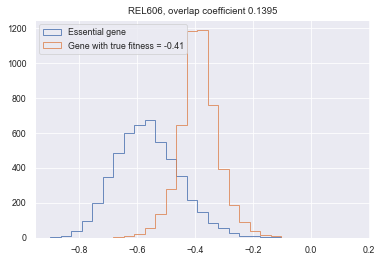

overlap coefficient 0.1321


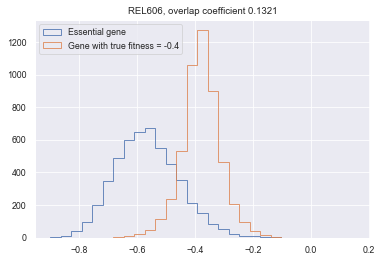

overlap coefficient 0.1187


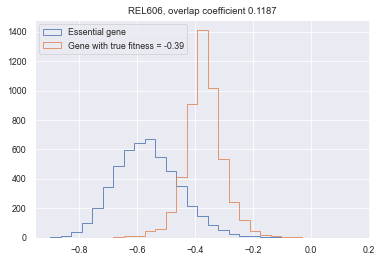

overlap coefficient 0.1136


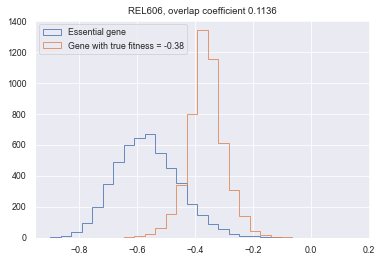

overlap coefficient 0.1001


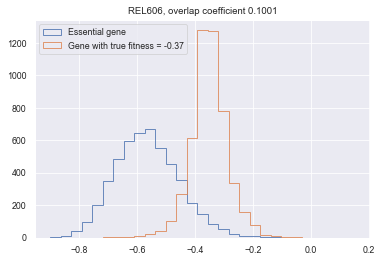

overlap coefficient 0.0896


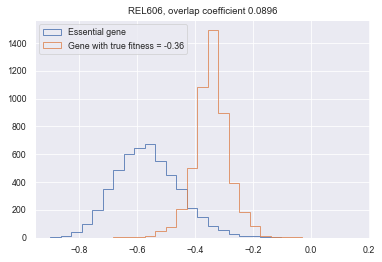

overlap coefficient 0.0788


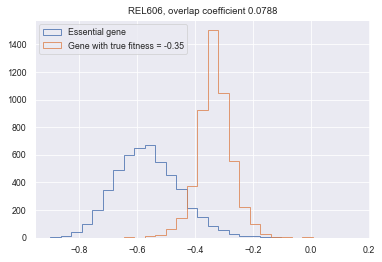

overlap coefficient 0.0754


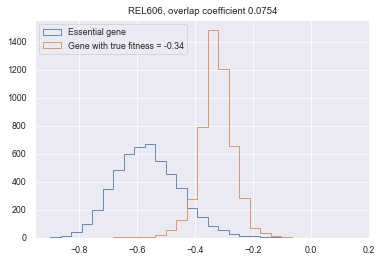

overlap coefficient 0.0702


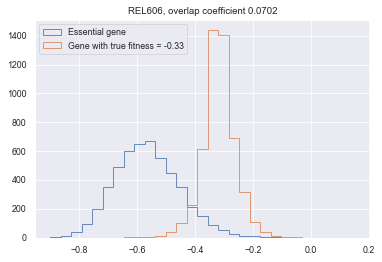

overlap coefficient 0.0632


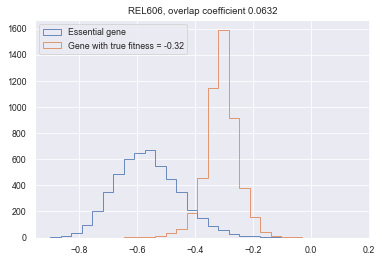

overlap coefficient 0.056


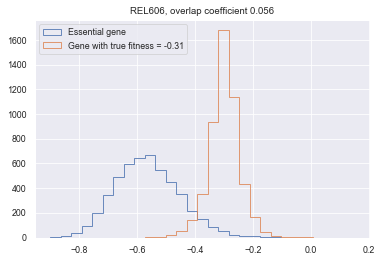

overlap coefficient 0.0513


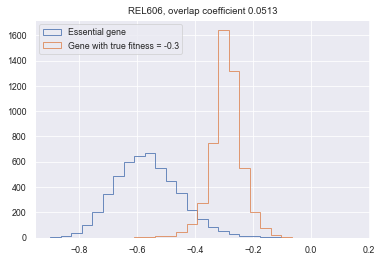

overlap coefficient 0.0452


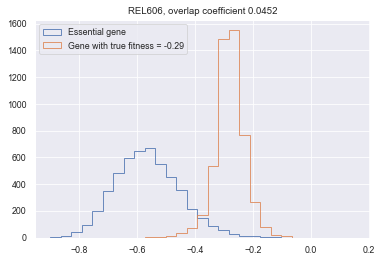

overlap coefficient 0.0402


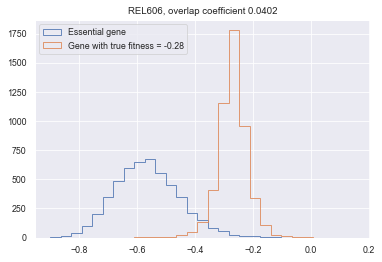

overlap coefficient 0.0376


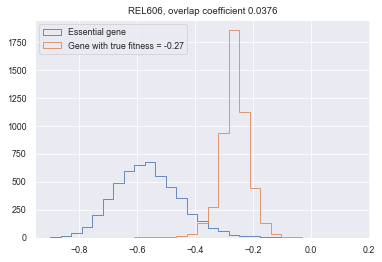

overlap coefficient 0.0319


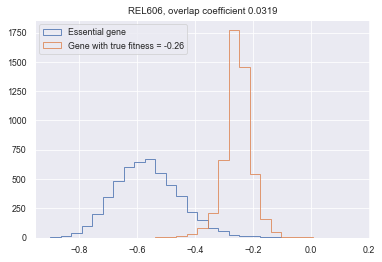

overlap coefficient 0.0285


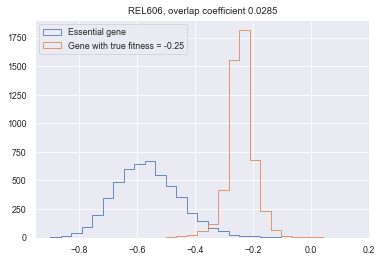

overlap coefficient 0.0248


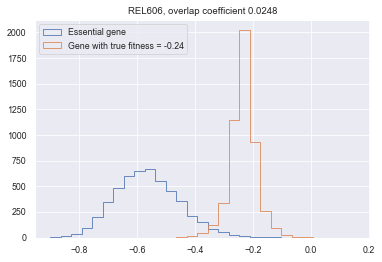

overlap coefficient 0.0219


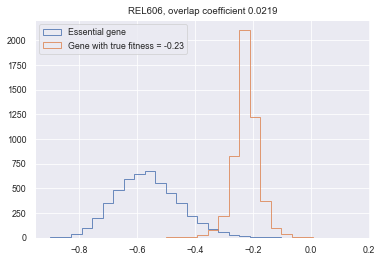

overlap coefficient 0.0189


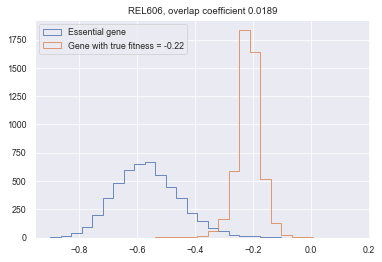

overlap coefficient 0.015


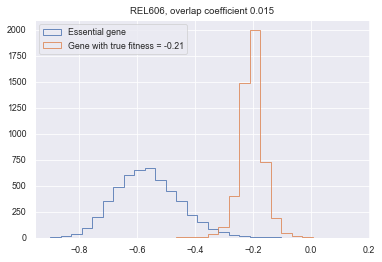

overlap coefficient 0.0142


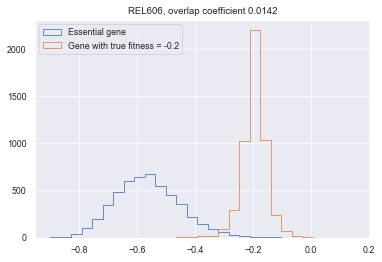

In [60]:
#min_s_estimate: for essential genes with a lognormal distribution fit.

#now, I'm going to iterate over a range of fitness effects and compute the distribution of fitness estimates given a
#true fitness estimate

s_range = np.linspace(-0.45, -0.2, 26)
bins = np.linspace(-0.9, 0.15, 30)

for s in s_range:
    #generating random variables from the lognormal distribution
    norm_fit = np.exp(norm.rvs(param4, param5, size=5000))
    #dilution ratio
    dilution = np.exp(s*6.64)
    xnorm_t1 = np.random.poisson(lam=norm_fit*dilution, size=5000)
    #fitness estimate:
    s_dist = np.log((xnorm_t1+offset)/(norm_fit+offset))/6.64
    a = plt.hist(min_s_estimate3, bins=bins, label='Essential gene', histtype='step')
    b = plt.hist(s_dist, bins=bins, label=f'Gene with true fitness = {np.round(s,3)}',histtype='step')
    print('overlap coefficient', np.sum(np.minimum(a[0],b[0]))/10**4)
    plt.legend(loc=2)
    plt.title('REL606, overlap coefficient '+str(np.sum(np.minimum(a[0],b[0]))/10**4))
    plt.show()
#     b = plt.hist(s_dist, bins=30, label=f'Gene with true fitness = {s}',histtype='step')
#     plt.title(f'Expected measurement variability for genes that have true fitness = {np.round(s,3)}')
#     plt.show()

#### Both of these approaches work well, and have pretty much the same result (-0.3 vs -0.29), depending on the specific simulation run

### Making publication quality plot

Will use the gamma distribution fit for estimating the threshold

In [41]:
figpath = repo +'/Analysis/Plots_for_paper/'

overlap coefficient 0.0464


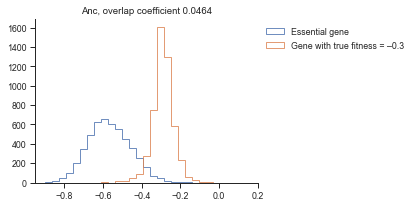

In [69]:
s=-0.3
with sns.axes_style('ticks'):
#generating random variables from the lognormal distribution
    plt.figure(figsize=(4,3))
    gamma_fit = np.exp(gamma.rvs(a1,loc1,scale1,size=5000))
    #dilution ratio
    dilution = np.exp(s*6.64)
    xgamma_t1 = np.random.poisson(lam=gamma_fit*dilution, size=5000)
    #fitness estimate:
    s_dist = np.log((xgamma_t1+offset)/(gamma_fit+offset))/6.64
    a = plt.hist(min_s_estimate2, bins=bins, label='Essential gene', histtype='step')
    b = plt.hist(s_dist, bins=bins, label=f'Gene with true fitness = –{np.abs(np.round(s,3))}',histtype='step')
    print('overlap coefficient', np.sum(np.minimum(a[0],b[0]))/10**4)
    plt.legend(bbox_to_anchor=(1,1),frameon=False)
    plt.title('Anc, overlap coefficient '+str(np.sum(np.minimum(a[0],b[0]))/10**4))
    sns.despine()
    plt.savefig(figpath+'essentiality_threshold_simulation.pdf', format='pdf', bbox_inches='tight')
    plt.show()